In [1]:
import torch
from torch import nn as nn
from torch import optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
# Trainset
transform = transforms.ToTensor()
all_mnist_train = MNIST('data/', download=True, train=True, transform=transform)
mnist_train = Subset(all_mnist_train, range(10000))

In [3]:
# Testset
all_mnist_test = MNIST('data/', download=True, train=False, transform=transform)
mnist_test = Subset(all_mnist_test, range(6000))
mnist_test

In [4]:
# dataloader
num_workers = 0
batch_size = 128

mnist_trainset = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers)
mnist_testset = DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers)
mnist_trainset

In [5]:
images, labels = next(iter(mnist_trainset))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [6]:
def plot_images(images, labels=labels, col=2):
    num_images = len(images)
    
    row = int(np.ceil(num_images/col))
    col = col
    fig, axes = plt.subplots(row, col)
    
    for i in range(row):
        for j in range(col):
            if i*col+j < num_images:
                axes[i, j].imshow(np.squeeze(images[i*col+j]), cmap='gray')
                if len(labels):
                    axes[i, j].set_title(f'{labels[i*col+j].item()}')

    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.show()

In [7]:
class SDAE(nn.Module):
    def __init__(self, input_size, latent_dim, hidden_layers=[512, 128, 32]):
        super().__init__()
        self.encoder = self.encoder_net(input_size, latent_dim, hidden_layers)
        self.decoder = self.decoder_net(input_size, latent_dim, hidden_layers)
        
    def encoder_net(self, X_size, latent_dim, hidden_layers):
        encoder = nn.Sequential()
        if hidden_layers:
            for i in range(len(hidden_layers)):
                if i == 0:
                    encoder.append(nn.Linear(X_size, hidden_layers[i]))
                    encoder.append(nn.ReLU())
                    continue
                encoder.append(nn.Linear(hidden_layers[i-1],hidden_layers[i]))
                encoder.append(nn.ReLU())
            encoder.append(nn.Linear(hidden_layers[-1], latent_dim))
            encoder.append(nn.ReLU())
        else:
            encoder.append(nn.Linear(X_size, latent_dim))
            encoder.append(nn.ReLU())
        return encoder

    def decoder_net(self, X_size, latent_dim, hidden_layers):
        hidden_layers.reverse()
        decoder = nn.Sequential()
        if hidden_layers:
            for i in range(len(hidden_layers)):
                if i == 0:
                    decoder.append(nn.Linear(latent_dim, hidden_layers[i]))
                    decoder.append(nn.ReLU())
                    continue
                decoder.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
                decoder.append(nn.ReLU())
            decoder.append(nn.Linear(hidden_layers[-1], X_size))
            decoder.append(nn.Sigmoid())
        else:
            decoder.append(nn.Linear(latent_dim, X_size))
            decoder.append(nn.Sigmoid())
        return decoder


    def forward(self, X):
        return self.decoder(self.encoder(X))

    def gaussian_noise(self, X, p=0.2):
        return (X + torch.normal(0, p, X.shape)).clip(0, 1)

    def masking_noise(self, X, p=0.7):
        a = p * torch.ones(X.shape)
        return X * torch.bernoulli(a)

    def poisson_noise(self, X, gain=5):
        a = gain * torch.ones(X.shape)
        p = torch.poisson(a)
        return p/p.max()

    def fit(self, X, lr=0.1, p=0.2, gain=1, noise='gaussian', optimizer='Adam', loss='BCELoss', epochs=20, batch_size=128, shuffle=True, num_workers=0):
        optimizer = getattr(optim, optimizer)(self.parameters(), lr=lr)
        loss_fn = getattr(nn, loss)()
        
        mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
        for epoch in range(1, epochs+1):
            train_loss = 0.0
            batch_num = 0
    
            for data in mnist_trainset:
                images, _ = data
                if noise == 'gaussian':
                    noised_images = self.gaussian_noise(images, p=p)
                elif noise == 'masking':
                    noised_images = self.masking_noise(images, p=p)
                elif noise == 'poisson':
                    noised_images = self.poisson_noise(images, gain=gain)
    
                optimizer.zero_grad()
                noised_images = noised_images.view(images.size(0), -1)
                y_hat = self.forward(noised_images)
                loss = loss_fn(y_hat, images.view(images.size(0), -1))
                loss.backward()
                optimizer.step()
    
                print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {loss.item()*noised_images.size(0):.6f}', end='\r')
                train_loss += loss.item()*noised_images.size(0)
                batch_num += noised_images.size(0)
    
            train_loss = train_loss / len(mnist_trainset)
            print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {train_loss:.6f}')

    def predict_encoder(self, X, batch_size=128):
        result = torch.tensor([])
    
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)
    
        for i, data in enumerate(mnist_testset):
            images, _ = data
            images = images.view(images.size(0), -1)
            result = torch.concat([result, self.encoder(images)], axis=0)           
        return result

    def predict_decoder(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        return self.decoder(X)

    def predict(self, X, batch_size=128):
        result = torch.tensor([])
    
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)
    
        for i, data in enumerate(mnist_testset):
            try:
                images, _ = data
            except:
                images = data
            images = images.view(images.size(0), -1)
            result = torch.concat([result, self.forward(images)], axis=0)
        return result

In [8]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [9]:
dae = SDAE(28*28, 64, hidden_layers=[])
dae

SDAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

In [10]:
dae.apply(init_weights)
dae.fit(mnist_train, epochs=20, lr=0.001, p=0.7, noise='masking', batch_size=20, optimizer='Adam', loss='MSELoss')

Epoch: 1 [10000/10000], Loss: 1.065049
Epoch: 2 [10000/10000], Loss: 0.570656
Epoch: 3 [10000/10000], Loss: 0.443511
Epoch: 4 [10000/10000], Loss: 0.373658
Epoch: 5 [10000/10000], Loss: 0.329806
Epoch: 6 [10000/10000], Loss: 0.303172
Epoch: 7 [10000/10000], Loss: 0.286408
Epoch: 8 [10000/10000], Loss: 0.275977
Epoch: 9 [10000/10000], Loss: 0.268852
Epoch: 10 [10000/10000], Loss: 0.263989
Epoch: 11 [10000/10000], Loss: 0.259767
Epoch: 12 [10000/10000], Loss: 0.255272
Epoch: 13 [10000/10000], Loss: 0.253113
Epoch: 14 [10000/10000], Loss: 0.251006
Epoch: 15 [10000/10000], Loss: 0.249103
Epoch: 16 [10000/10000], Loss: 0.248843
Epoch: 17 [10000/10000], Loss: 0.247442
Epoch: 18 [10000/10000], Loss: 0.245263
Epoch: 19 [10000/10000], Loss: 0.244368
Epoch: 20 [10000/10000], Loss: 0.243513


In [38]:
def plot_generated_images(images, labels=None, model=dae, noise='masking', p=0.7, gain=1):
    row = len(images)
    col = 3
    fig, axes = plt.subplots(row, col)
    if noise == 'masking':
        noisy_images = model.masking_noise(images, p=p)
    elif noise == 'gaussian':
        noisy_images = model.gaussian_noise(images, p=p)
    else:
        noisy_images = model.poisson_noise(images, gain=gain)

    generated_images = model.predict(noisy_images).detach().numpy().reshape(-1, 28,28)
    
    for i in range(row):
        for j in range(col):
            if j == 0:
                axes[i, j].imshow(np.squeeze(generated_images[i]), cmap='gray')
                if len(labels):
                    axes[i, j].set_title(f'Generated: {labels[i].item()}')
                continue
            if j == 1:
                axes[i, j].imshow(np.squeeze(noisy_images[i]), cmap='gray')
                if len(labels):
                    axes[i, j].set_title(f'{noise} noise: {labels[i].item()}')
                continue
            axes[i, j].imshow(np.squeeze(images[i]), cmap='gray')
            if len(labels):
                axes[i, j].set_title(f'Original: {labels[i].item()}')

    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.show()

torch.Size([5, 28, 28])


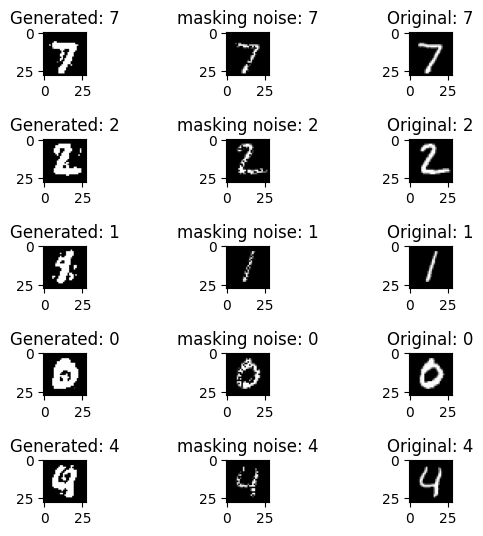

In [35]:
num = 5
plot_generated_images(all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num], model=dae, noise='masking', p=0.7)

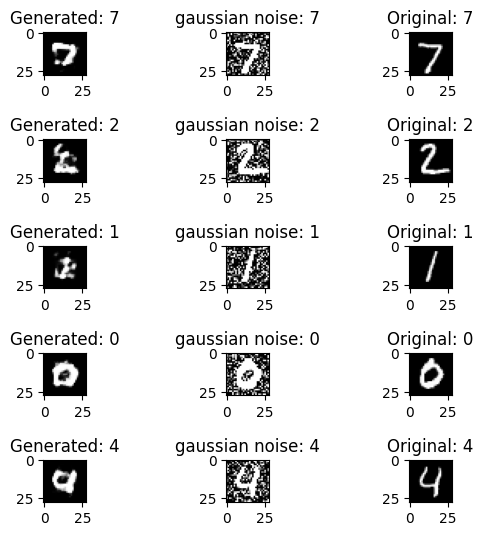

In [13]:
num = 5
plot_generated_images(all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num], model=dae, noise='gaussian', p=0.9)

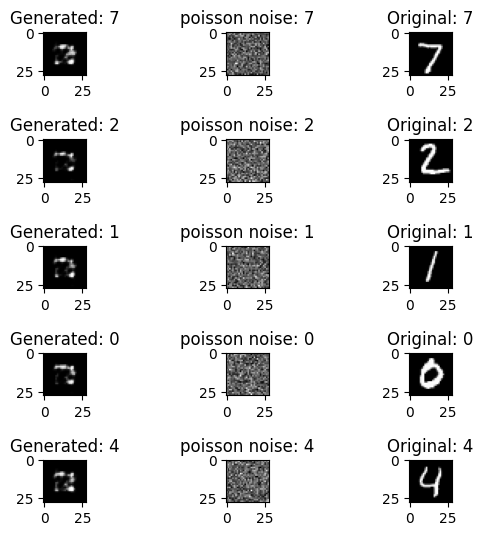

In [14]:
num = 5
plot_generated_images(all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num], model=dae, noise='poisson', p=0.7, gain=5)

In [15]:
encoders = dae.predict_encoder(mnist_test, batch_size=256)
encoders.shape

torch.Size([6000, 64])

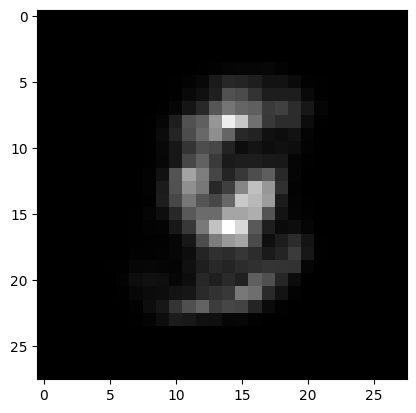

In [18]:
plt.imshow(dae.predict_decoder([np.random.uniform(4, 5) for _ in range(64)]).detach().numpy().reshape(28, 28), cmap='gray')

In [19]:
sdae = SDAE(28*28, 2, hidden_layers=[256, 64, 16])
sdae

SDAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [20]:
sdae.apply(init_weights)
sdae.fit(mnist_train, epochs=20, lr=0.001, p=0.7, gain=5, noise='masking', batch_size=20, optimizer='Adam', loss='MSELoss')

Epoch: 1 [10000/10000], Loss: 1.404637
Epoch: 2 [10000/10000], Loss: 1.174790
Epoch: 3 [10000/10000], Loss: 1.151582
Epoch: 4 [10000/10000], Loss: 1.127957
Epoch: 5 [10000/10000], Loss: 1.105394
Epoch: 6 [10000/10000], Loss: 1.084928
Epoch: 7 [10000/10000], Loss: 1.070977
Epoch: 8 [10000/10000], Loss: 1.065085
Epoch: 9 [10000/10000], Loss: 1.050503
Epoch: 10 [10000/10000], Loss: 1.040694
Epoch: 11 [10000/10000], Loss: 1.038753
Epoch: 12 [10000/10000], Loss: 1.026983
Epoch: 13 [10000/10000], Loss: 1.024025
Epoch: 14 [10000/10000], Loss: 1.013126
Epoch: 15 [10000/10000], Loss: 1.007909
Epoch: 16 [10000/10000], Loss: 1.000635
Epoch: 17 [10000/10000], Loss: 1.001283
Epoch: 18 [10000/10000], Loss: 0.999502
Epoch: 19 [10000/10000], Loss: 0.998533
Epoch: 20 [10000/10000], Loss: 0.991019


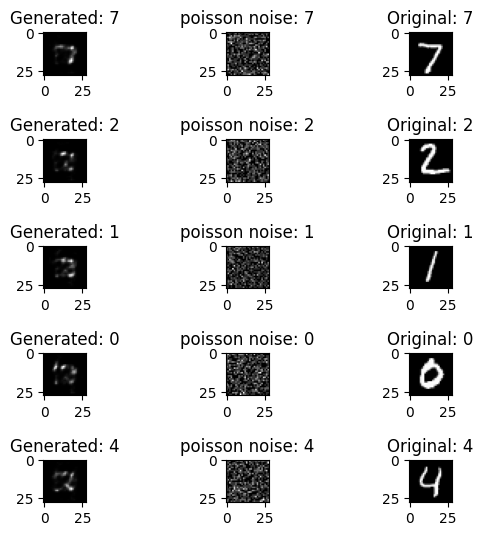

In [23]:
num = 5
plot_generated_images(all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num], model=dae, noise='poisson', p=0.7, gain=1)

In [44]:
class ConvSDAE(nn.Module):
    def __init__(self, input_size, latent_dim):
        super().__init__()
        self.encoder = self.encoder_net(input_size, latent_dim,)
        self.decoder = self.decoder_net(input_size, latent_dim,)
        
    def encoder_net(self, X_size, latent_dim):
        encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(64, 128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Flatten(),
            nn.Linear(1152, latent_dim),
            nn.ReLU(),
        )
        return encoder

    def decoder_net(self, X_size, latent_dim):
        decoder = nn.Sequential(
            nn.Linear(latent_dim, 1152),
            nn.Unflatten(1, (128, 3, 3)),
            nn.ConvTranspose2d(128, 64, kernel_size = (3,3), stride = (2,2), padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = (2,2), stride = 3, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = (2,2), stride = 2, padding=(0,0)),
            nn.Sigmoid()   
        )
        return decoder


    def forward(self, X):
        return self.decoder(self.encoder(X))

    def gaussian_noise(self, X, p=0.2):
        return (X + torch.normal(0, p, X.shape)).clip(0, 1)

    def masking_noise(self, X, p=0.7):
        a = p * torch.ones(X.shape)
        return X * torch.bernoulli(a)

    def poisson_noise(self, X, gain=5):
        a = gain * torch.ones(X.shape)
        p = torch.poisson(a)
        return p/p.max()

    def fit(self, X, lr=0.1, p=0.2, gain=1, noise='gaussian', optimizer='Adam', loss='BCELoss', epochs=20, batch_size=128, shuffle=True, num_workers=0):
        optimizer = getattr(optim, optimizer)(self.parameters(), lr=lr)
        loss_fn = getattr(nn, loss)()
        
        mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
        for epoch in range(1, epochs+1):
            train_loss = 0.0
            batch_num = 0
    
            for data in mnist_trainset:
                images, _ = data
                if noise == 'gaussian':
                    noised_images = self.gaussian_noise(images, p=p)
                elif noise == 'masking':
                    noised_images = self.masking_noise(images, p=p)
                elif noise == 'poisson':
                    noised_images = self.poisson_noise(images, gain=gain)
    
                optimizer.zero_grad()
                noised_images = noised_images.view(-1, 1, 28, 28)
                y_hat = self.forward(noised_images)
                loss = loss_fn(y_hat.view(-1, 1, 28, 28), images)
                loss.backward()
                optimizer.step()
    
                print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {loss.item()*noised_images.size(0):.6f}', end='\r')
                train_loss += loss.item()*noised_images.size(0)
                batch_num += noised_images.size(0)
    
            train_loss = train_loss / len(mnist_trainset)
            print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {train_loss:.6f}')

    def predict_encoder(self, X, batch_size=128):
        result = torch.tensor([])
    
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)
    
        for i, data in enumerate(mnist_testset):
            images, _ = data
            images = images.view(-1, 1, 28, 28)
            result = torch.concat([result, self.encoder(images)], axis=0)           
        return result

    def predict_decoder(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        return self.decoder(X)

    def predict(self, X, batch_size=128):
        result = torch.tensor([])
    
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)
    
        for i, data in enumerate(mnist_testset):
            try:
                images, _ = data
            except:
                images = data
            images = images.view(-1, 1, 28, 28)
            result = torch.concat([result, self.forward(images)], axis=0)
        return result

In [45]:
csdae = ConvSDAE(28*28, 64)
csdae

ConvSDAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=64, bias=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=1152, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(128, 3, 3))
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(

In [49]:
csdae.apply(init_weights)
csdae.fit(mnist_train, epochs=20, lr=0.001, p=0.7, gain=1, noise='masking', batch_size=20, optimizer='NAdam', loss='MSELoss')

Epoch: 1 [10000/10000], Loss: 1.209174
Epoch: 2 [10000/10000], Loss: 1.132921
Epoch: 3 [10000/10000], Loss: 1.116392
Epoch: 4 [10000/10000], Loss: 1.108831
Epoch: 5 [10000/10000], Loss: 1.102197
Epoch: 6 [10000/10000], Loss: 1.097231
Epoch: 7 [10000/10000], Loss: 1.093624
Epoch: 8 [10000/10000], Loss: 1.090726
Epoch: 9 [10000/10000], Loss: 1.087695
Epoch: 10 [10000/10000], Loss: 1.085376
Epoch: 11 [10000/10000], Loss: 1.083563
Epoch: 12 [10000/10000], Loss: 1.081572
Epoch: 13 [10000/10000], Loss: 1.080036
Epoch: 14 [10000/10000], Loss: 1.078664
Epoch: 15 [10000/10000], Loss: 1.077061
Epoch: 16 [10000/10000], Loss: 1.075965
Epoch: 17 [10000/10000], Loss: 1.074946
Epoch: 18 [10000/10000], Loss: 1.074082
Epoch: 19 [10000/10000], Loss: 1.073192
Epoch: 20 [10000/10000], Loss: 1.072259


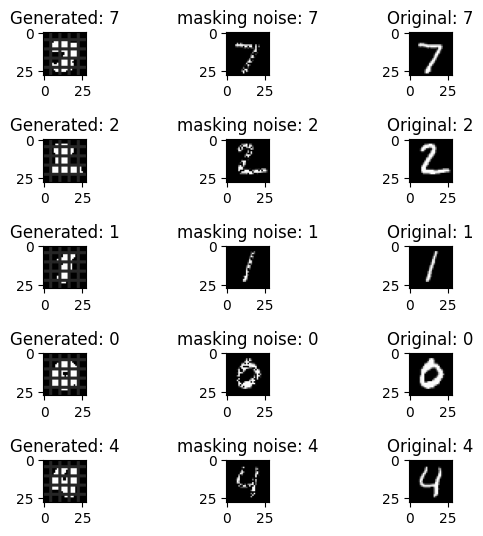

In [52]:
num = 5
plot_generated_images(all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num], model=csdae, noise='masking', p=0.7, gain=1)